In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Step-1

# Reading and Utilizing Provided Data

In [3]:
patient_data=pd.read_csv('/content/drive/MyDrive/Classification-of-Lung-Sound/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])

<ipython-input-4-e5a4f8d543be>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='viridis')


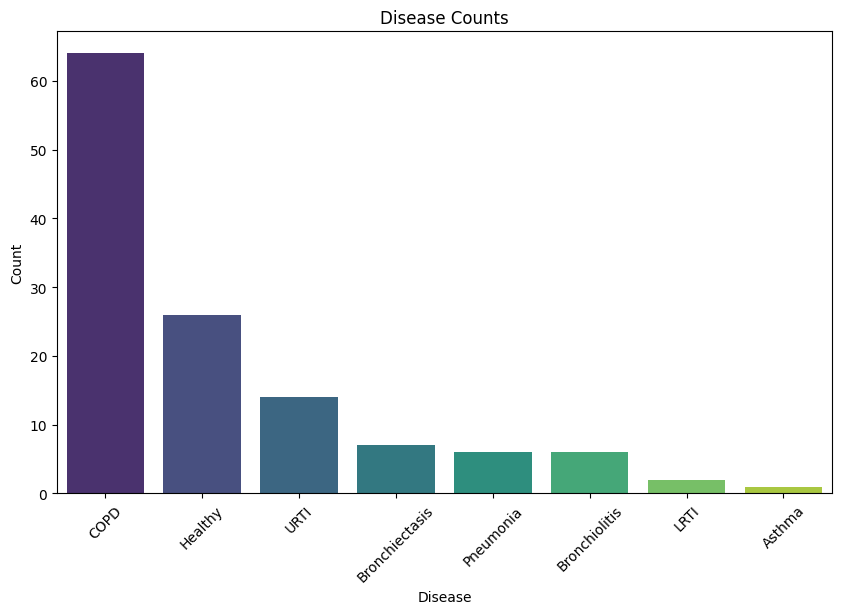

In [4]:

# Load the data
df = patient_data

# Count the occurrences of each category in the 'disease' column
disease_counts = df['disease'].value_counts()

# Plot using Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x=disease_counts.index, y=disease_counts.values, palette='viridis')
plt.xlabel('Disease')
plt.ylabel('Count')
plt.title('Disease Counts')
plt.xticks(rotation=45)
plt.show()


In [ ]:
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


* Here we have Patient Ids and Disease info
  

> Lets check out what is in annoted '.txt' files of audio files.

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Classification-of-Lung-Sound/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Al_mc_AKGC417L.txt',sep='\t')
df.head()

,1.862,5.718,0,1
0,5.718,9.725,1,1
1,9.725,13.614,0,1
2,13.614,17.671,0,1
3,17.671,19.541,0,0


* These are very usefull information namely (Start , End ( time of respiratory cycles) ,crackles,weezels)

> So lets get them into a dataset

> Note:- i use sep **' \t '** cause we are reading data from text file which is sperated by tabs here

In [ ]:
import os
path='/content/drive/MyDrive/Classification-of-Lung-Sound/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['160_1b4_Tc_mc_AKGC417L',
 '160_1b4_Al_mc_AKGC417L',
 '160_1b4_Lr_mc_AKGC417L',
 '160_2b3_Lr_mc_AKGC417L',
 '160_1b4_Ar_mc_AKGC417L']

> As mentioned in **filename_format.txt** , '.txt' files of annotated audio files have various information. So we will try to extract that too.  

In [ ]:
def getFilenameInfo(file):
    return file.split('_')

In [ ]:
getFilenameInfo('160_1b3_Al_mc_AKGC417L')

['160', '1b3', 'Al', 'mc', 'AKGC417L']

> Here useful info  is [Patient ID, __ ,__ ,Type(mono,stereo), __ ]

In [ ]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','weezels'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,1.962,6.553,0,1,160,mc,160_1b4_Tc_mc_AKGC417L
1,6.553,11.160,0,1,160,mc,160_1b4_Tc_mc_AKGC417L
2,11.160,15.401,0,1,160,mc,160_1b4_Tc_mc_AKGC417L
3,15.401,19.841,0,1,160,mc,160_1b4_Tc_mc_AKGC417L
0,1.962,6.553,1,1,160,mc,160_1b4_Al_mc_AKGC417L


> Now we can join both **patient_data** and **files_df**

In [ ]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6898 entries, 0 to 4
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   weezels   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


> Lets get **pid** and **101** to same type and merge both dataframes on pid

In [ ]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

In [ ]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,weezels,pid,mode,filename,disease
0,1.962,6.553,0,1,160,mc,160_1b4_Tc_mc_AKGC417L,COPD
1,6.553,11.160,0,1,160,mc,160_1b4_Tc_mc_AKGC417L,COPD
2,11.160,15.401,0,1,160,mc,160_1b4_Tc_mc_AKGC417L,COPD
3,15.401,19.841,0,1,160,mc,160_1b4_Tc_mc_AKGC417L,COPD
4,1.962,6.553,1,1,160,mc,160_1b4_Al_mc_AKGC417L,COPD


In [ ]:
os.makedirs('csv_data', exist_ok=True)
data.to_csv('csv_data/data.csv', index=False)


# Step 2

# Processing Audio files

> Now we only want that parts from whole audio file which contains **Respiratory Cycles**

> We can do this by utilizing the start and end time specifiles for these cycles in our **data dataframe**

In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and spilts its using start and end args

    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo

    '''
    max_ind = len(raw_data)
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

* we multiplied start with sampling rate cause start is time and raw_data is array sampled acc. to sampling rate

> Now we also want our input images to our cnn to be of same size for that audio files must be of **same length** i.e **(start - end)** must be same

> Lets find the best length we can have

<Axes: xlabel='None', ylabel='pid'>

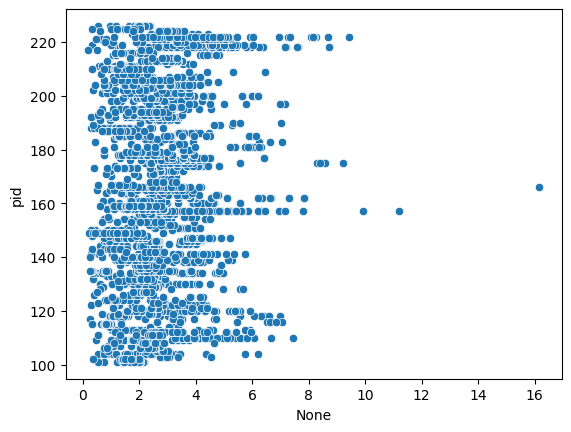

In [ ]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

<Axes: ylabel='None'>

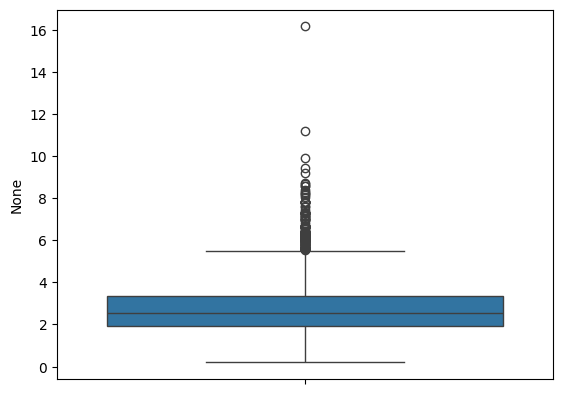

In [ ]:
sns.boxplot(y=(data.end-data.start))

> From these plots we can conclude that best length is **~6**

> Also if difference is <6 we must **Zero Pad** it to get it to required length

> Zero Padding means **silent**


> Lets create a directory for storing our files

In [ ]:
os.makedirs('processed_audio_files', exist_ok=True)


* We can iterate over dataset using iterrows, its output is as shown

In [ ]:
for index,row in data.iterrows():
    print("Index ->",index)
    print("Data->\n",row)
    break

Index -> 0
Data->
 start                        1.962
end                          6.553
crackles                         0
weezels                          1
pid                            160
mode                            mc
filename    160_1b4_Tc_mc_AKGC417L
disease                       COPD
Name: 0, dtype: object


 Also a single sample of audio file can have **Many Respiratory Cycles** so we might have to same multiple files for a simple audio file

> I will be using **Librosa** module for loading audio files and **Soundfile** module for writing to output path

> **Study The following Function Carefully**

In [ ]:
import librosa as lb
import soundfile as sf
import os

path = '/path/to/original/audio/files/'  # Set the correct path
save_path = '/content/drive/MyDrive/Classification-of-Lung-Sound/processed_audio_files/'
maxLen = 6  # seconds
c = 0

for index, row in data.iterrows():
    start, end = row['start'], row['end']
    filename = row['filename']

    if end - start > maxLen:
        end = start + maxLen

    audio_file_loc = os.path.join(path, filename + '.wav')

    if index > 0 and data.iloc[index - 1]['filename'] == filename:
        i += 1
    else:
        i = 0

    new_filename = filename + '_' + str(i) + '.wav'
    save_file_loc = os.path.join(save_path, new_filename)
    c += 1

    try:
        audioArr, sampleRate = lb.load(audio_file_loc)
        pureSample = getPureSample(audioArr, start, end, sampleRate)
        reqLen = 6 * sampleRate
        padded_data = lb.util.pad_center(pureSample, size=reqLen, axis=0)
        sf.write(file=save_file_loc, data=padded_data, samplerate=sampleRate)
    except Exception as e:
        print(f"Error processing file {audio_file_loc}: {e}")

print('Total Files Processed:', c)
